# Dimensionality Reduction

In this lab, we will work with an IMDB dataset to estimate the sentiment of movie reviews. We will study PCA and Sparse PCA in this context, and work using Single Value Decomposition to perform topic analysis. In the context of text mining, we call SVD *Latent Semantic Analysis* (LSA).

LSA is already implemented in Python in scikit-learn in the package [*TruncatedSVD*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), we will use that along with the Natural Language Processing library [*NLTK*](https://www.nltk.org/) for our methods.

The general process can be summarized as follows:

1. Load the text in free form.
2. Preprocess the text to normalize it.
3. Calculate LSA.
4. Explore the results.

## Loading text: IMDB database.

This dataset comes from the website Internet Movie Database, and represents 25,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. It is a pretty big dataset, so we will work with small samples of 500 positive cases and 500 negative cases.

The uncompressed data is simply a series of text documents, each in its own text file, stored in two classes (Positive and Negative), one per folder: 

The first step is to load the data and create a "corpus". A corpus is, quite simply, a set of documents. Here, we will read the files from our folders, and assign it a sentiment. We need to read the documents one by one, and store them into a data object which will have the texts and a tag highlighting whether they are positive or negative.

### Reading the text

The first step is to read the data into a vector. We need to read from the document path, using the internal system. This package is called `os` and comes pre-installed in Python.


In [2]:
# imports
import os
import numpy as np; seed = 2316; np.random.seed(seed)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from   scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from   sklearn.decomposition import PCA, SparsePCA, TruncatedSVD

# https://scikit-learn.org/stable/modules/manifold.html
from   sklearn.manifold import TSNE

# UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
# https://umap-learn.readthedocs.io/en/latest/
# !pip install umap-learn 
# !pip install datashader bokeh holoviews scikit-image colorcet ipywidgets
import umap
import umap.plot # good for plotting gigantic data

/Users/david/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/david/Library/Python/3.9/lib/python/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
# First, extract the files from the given zip file
# !unzip -qq LSA_Sample.zip

In [4]:
# List all files in the positive samples. Replace with your own!
dir = './Lecture_Sample/train/pos/'
fileList = os.listdir(dir)

# Create vector with texts
outtexts = []

# Read the files in the directory and append them with the class to the dataset
for eachFile in fileList:
    with open(dir + eachFile, 'rb', newline = None) as _fp:
        fileData = _fp.read()
        outtexts.append(fileData)
    _fp.close()
    
# Create dataframe from outputs
texts = pd.DataFrame({'texts': outtexts, 'class': 1})
texts.head()

,texts,class
0,b'Zentropa has much in common with The Third M...,1
1,b'When you actually find a video game to be sc...,1
2,"b""This is a wonderful new crime series, bringi...",1
3,"b""Fortunately for us Real McCoy fans (most lik...",1
4,b'A movie of outstanding brilliance and a poig...,1


In [5]:
# Repeat for negative values
# List all files in the "pos" directory
dir = 'Lecture_Sample/train/neg/'
fileList = os.listdir(dir)

# Create vector with texts
outtexts = []

# Read the files in the directory and append them with the class to the dataset
for eachFile in fileList:
    with open(dir + eachFile, 'rb', newline = None) as _fp:
        fileData = _fp.read()
        outtexts.append(fileData)
    _fp.close()
    
# Create dataframe from outputs
texts = pd.concat((texts, pd.DataFrame({'texts': outtexts, 'class': 0})), ignore_index = True)
texts.tail()

,texts,class
995,"b""I don't normally feel much of an incentive t...",0
996,"b'Even if you\'re a huge Sandler fan, please d...",0
997,"b""I saw this DVD in my friends house and thoug...",0
998,"b""When converting a book to film, it is genera...",0
999,"b""If I had not read Pat Barker's 'Union Street...",0


In [6]:
texts.describe()

,class
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [7]:
texts

,texts,class
0,b'Zentropa has much in common with The Third M...,1
1,b'When you actually find a video game to be sc...,1
2,"b""This is a wonderful new crime series, bringi...",1
3,"b""Fortunately for us Real McCoy fans (most lik...",1
4,b'A movie of outstanding brilliance and a poig...,1
...,...,...
995,"b""I don't normally feel much of an incentive t...",0
996,"b'Even if you\'re a huge Sandler fan, please d...",0
997,"b""I saw this DVD in my friends house and thoug...",0
998,"b""When converting a book to film, it is genera...",0


The text is quite dirty, so we'll use regex code to clean it. It is available in Python using the package [re](https://www.rexegg.com/regex-quickstart.html). Regex can be daunting, but it is very rewarding to learn. Do spend some time with it!

In [8]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    html = raw_html.decode('ISO-8859-1') # Change the encoding to your locale!
    cleantext = re.sub(CLEANR, '', html)
    return cleantext

texts['texts'] = texts['texts'].apply(cleanhtml)
texts

,texts,class
0,Zentropa has much in common with The Third Man...,1
1,When you actually find a video game to be scar...,1
2,"This is a wonderful new crime series, bringing...",1
3,Fortunately for us Real McCoy fans (most likel...,1
4,A movie of outstanding brilliance and a poigna...,1
...,...,...
995,I don't normally feel much of an incentive to ...,0
996,"Even if you're a huge Sandler fan, please don'...",0
997,I saw this DVD in my friends house and thought...,0
998,"When converting a book to film, it is generall...",0


Now we will transform the text. The following code uses sklearn's [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) which applies a [Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) transformation to the text ( which means counting how many times a certain concept, *e.g.*, a word, appears in the document versus the total times it appears in the document) to do the following:

1. Eliminate accents and other characters.
2. Eliminate the so-called "stopwords", or words that are irrelevant to the learning given they are only connectors. These words are [here](https://gist.github.com/ethen8181/d57e762f81aa643744c2ffba5688d33a).
3. Eliminate concepts that are rare (min_df) or too common (max_df). Here we eliminate concepts that appear in less than 5% of documents and those that appear in over 90%.

The last argument calculates a logaritmic (or sublinear) transformation, which is more robust. This effectively transforms our text data into a fully numeric dataset!


In [9]:
# Transform the text
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.90, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus), i.e., replace tf with 1 + log(tf)
                      )

The model structure of scikit-learn follows always the same:

1. We define the model using the appropriate function directly from the package (as above).

2. We train the model using the "fit" method over the object we created in 1.

3. We apply the model to data using the "transform" method.

In cases where we want to fit *and* transform the inputs - such as a TF-IDF transform, which is applied over the same data where the weights are "trained" - we can use directly the method "fit_transform", that performs steps 2 and 3 directly.

In [10]:
TfIDF_IMDB = TfIDFTransformer.fit_transform(texts['texts'])
TfIDF_IMDB

<1000x230 sparse matrix of type '<class 'numpy.float64'>'
	with 23848 stored elements in Compressed Sparse Row format>

It's sparse because not every word appears in every document, leading to null entries. These matrices only store the relevant information! They are much more efficient in memory use and compute time. Unlike operations with dense matrices, operations with sparse matrices do not perform unnecessary low-level arithmetic, such as zero-adds (x+0 is always x). The resulting efficiencies can lead to dramatic improvements in execution time for programs working with large amounts of sparse data. For a full matrix, you store 8 bytes (one double) per entry. For a sparse matrix, you store 12 bytes per entry (one double for the value, and one integer for the column index of the entry).

Here, we have $23848$ sparse entries: $23848 \times 12=286176$ bytes, and in the case of dense we have $1000 \times 230 \times 8 = 1840000 $ bytes. Since $ 286176 < 1840000 $, using sparse should yield better computational efficiency. Use sparse as long as $ 23848 \times 12 < 1000 \times 230 \times 8 $ (or, $ 23848<67\% (1000 \times 230)$).

 `TfIdfVectorizer.fit_transform()` has a `toarray()` method if needed.

FYI: If you have a matrix with a lot of null entries, you could convert it to a sparse matrix using `from scipy.sparse import csr_matrix`.

In [11]:
data_size = TfIDF_IMDB.toarray().nbytes/(1024**2) # or 1000*230*8/(1024**2)
print('Size of dense matrix: '+ '%3.2f' %data_size + ' MB')

data_csr_size=TfIDF_IMDB.data.size/(1024**2)
print('Size of sparse csr_matrix: '+ '%3.2f' %data_csr_size + ' MB') # or 23848*12/(1024**2)

Size of dense matrix: 1.75 MB
Size of sparse csr_matrix: 0.02 MB


In [12]:
df1 = pd.DataFrame(TfIDF_IMDB.toarray(), columns=TfIDFTransformer.get_feature_names_out())
df1.head()

,10,absolutely,acting,action,actor,actors,actress,actually,american,audience,...,won,wonderful,work,world,worst,worth,wrong,year,years,young
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.274714,0.0,...,0.0,0.000000,0.210998,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.224854,0.000000,0.0,...,0.0,0.000000,0.335294,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.145355,0.000000,0.000000,0.000000,0.0,...,0.0,0.179743,0.000000,0.0,0.0,0.0,0.0,0.294274,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.168265,0.215895,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [13]:
vectorizer = sktext.CountVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.90, # Eliminate words that appear in more than 95% of texts
                      )
matrix = vectorizer.fit_transform(texts['texts'])
df2 = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(df2.shape)
df2.head()

(1000, 230)


,10,absolutely,acting,action,actor,actors,actress,actually,american,audience,...,won,wonderful,work,world,worst,worth,wrong,year,years,young
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,2,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,2,0,0
3,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Show us the top 10 most common words
df2.sum().T.sort_values(ascending=False).head(10)
# df2.sum().sum()

movie     1570
film      1529
like       749
just       657
good       567
story      547
time       472
really     409
people     361
great      336
dtype: int64

The output of the TF-IDF transformer is a sparse matrix. We can check the outputs of the first row with the below code.

In [15]:
print(TfIDF_IMDB[0,:])

  (0, 173)	0.26545801844158673
  (0, 128)	0.11195758421856515
  (0, 122)	0.2498153962053425
  (0, 19)	0.2498153962053425
  (0, 164)	0.20780936892312818
  (0, 205)	0.27807345905442127
  (0, 156)	0.17039846418164664
  (0, 47)	0.22878657692741408
  (0, 218)	0.2506033753579599
  (0, 73)	0.24903566829491317
  (0, 8)	0.27471364096452167
  (0, 222)	0.2109978887202084
  (0, 26)	0.2828028790649009
  (0, 175)	0.2758168216611378
  (0, 66)	0.12042103613155977
  (0, 107)	0.23290248502287883
  (0, 123)	0.3474015949969882


In [16]:
# and we can verify:
df1.iloc[0,173]

0.26545801844158673

 The following vector shows the list of words associated to each index for indices 30 to 39.

In [17]:
# Let's save the indexes for later.
word_index = TfIDFTransformer.get_feature_names_out()
print(word_index[30:40])

['cinema' 'classic' 'come' 'comedy' 'comes' 'completely' 'couldn' 'couple'
 'course' 'day']


## [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

You have an $n\times p$ data matrix $\boldsymbol X$, where $n$ is the number of samples and $p$ is the number of features. The singular value decomposition (SVD) of $\boldsymbol X$ gives three matrices $\boldsymbol{U\Sigma V}^*$. Combining the first two ($\boldsymbol {Z=U\Sigma}$) gives the matrix of principal components. $\boldsymbol {\Sigma }$ is a diagonal $p\times p$ matrix containing the singular values in descending order. $\boldsymbol {U}$ and $\boldsymbol {V}^*$ are unitary/orthogonal matrices (*i.e.*, rotation matrices).

$\boldsymbol V$ contains the principal loading vectors. This means that the principal components are derived by using the principal loadings as coefficients in a linear combination of your data matrix.

Once you have all the PCs (*i.e.*, $\boldsymbol {U\Sigma }$) figured out you can use the eigenvalues (the sum of squares of the distances from the origin after the projection of the datapoints to the PC, in other words, the square of singular values) to determine the proportion of variation that each PC accounts for.

Total variance explained by the first 2 components is 0.030.
The first 2 components explain 3.421% of total variance.


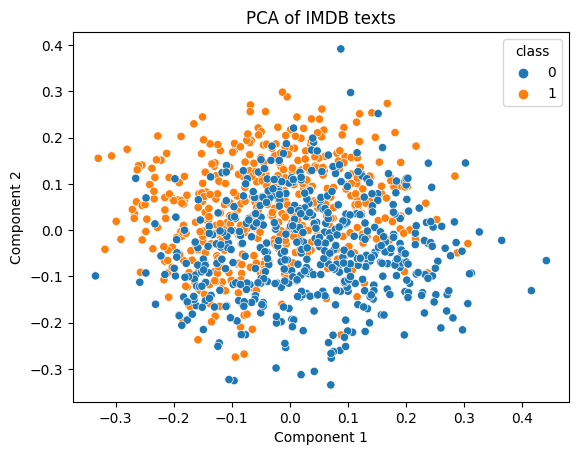

In [119]:
# Do normal PCA on the data set
n = 2 
nPCA = PCA(n_components=n, svd_solver='full')

# Now we fit. We need to transform our matrix to dense format first.
nPCA.fit(TfIDF_IMDB.toarray())

# Let's calculate the variance of the two components. (lambda_i over sum of lambdas gives amount of explained variance)
total_variance= np.sum(nPCA.explained_variance_)
print('Total variance explained by the first %i components is %.3f.' % (nPCA.n_components_, total_variance))

total_variance_ratio = np.sum(nPCA.explained_variance_ratio_)*100
print('The first %i components explain %.3f%% of total variance.' % (nPCA.n_components_, total_variance_ratio))

# Let's get the components and plot them, coloring by the class
Z1 = nPCA.transform(TfIDF_IMDB.toarray())
sns.scatterplot(x=Z1[:, 0], y=Z1[:, 1], hue=texts['class'])

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA of IMDB texts")
plt.show()

In [120]:
### SVD with numpy

X = TfIDF_IMDB.toarray()
X = X - X.mean(axis=0)
print("Shape of X:", X.shape)

u, s, vt = np.linalg.svd(X, full_matrices=False, compute_uv=True) # It's not necessary to compute the full matrix of U or V

# flip eigenvectors' sign to enforce deterministic output
def svd_flip(u, v):
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, range(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
        return u, v

u, vt = svd_flip(u, vt)

# The columns of u are the principal components scaled to unit norm.
print("\nShape of U:", u.shape)

print("Shape of S:", s.shape) 

# The columns of v contain the principal axes.
print("Shape of V.T:", vt.shape)

print("\nCan X be reconstructed using U, S, and V.T?\n{}".format(np.allclose(X, np.dot(u * s, vt))))

print("\nFirst {} singular values calculated manually:\n{}".format(n, s[:n]))

# get the singular values from sklearn
print("\nFirst {} singular values calculated by sklearn:\n{}".format(n, nPCA.singular_values_))

Shape of X: (1000, 230)

Shape of U: (1000, 230)
Shape of S: (230,)
Shape of V.T: (230, 230)

Can X be reconstructed using U, S, and V.T?
True

First 2 singular values calculated manually:
[4.13372449 3.62096289]

First 2 singular values calculated by sklearn:
[4.13372449 3.62096289]


To a obtain a reduced dataset $\boldsymbol X_{d}$, compute the matrix multiplication of the training set matrix $\boldsymbol X$ by the matrix containing the first $d$ eigenvectors (columns) of $\boldsymbol V$.

$\boldsymbol V$: Principal axes in feature space, representing the directions of maximum variance in the data.

In [153]:
print(X.shape)

d=2
(X@vt.T[:,:d]).shape # this gives a reduced dataset which is 2 dimensional

(1000, 230)


(1000, 2)

In [154]:
print(vt.shape)
vt[0,:5]

(230, 230)


array([ 0.02932715, -0.00449369,  0.04245523, -0.00183295, -0.0643395 ])

In [155]:
print(nPCA.components_.shape) # of shape (n_components, n_features)
nPCA.components_[0,:5]

(2, 230)


array([ 0.02932715, -0.00449369,  0.04245523, -0.00183295, -0.0643395 ])

In [156]:
loadings = pd.DataFrame(nPCA.components_.T, columns=['PC1', 'PC2'], index=word_index)
loadings.head(10)
# Principal axes in feature space, representing the directions of maximum variance in the data.
# Equivalently, the right singular vectors of the centered input data, parallel to its eigenvectors.

# The columns of the dataframe contain the eigenvectors associated
# with the first two principal components. Each element represents
# a loading, namely how much (the weight) each original variable
# contributes to the corresponding principal component.

,PC1,PC2
10,0.029327,-0.024457
absolutely,-0.004494,0.060245
acting,0.042455,-0.015352
action,-0.001833,-0.022488
actor,-0.064339,-0.021960
actors,0.022840,0.035704
actress,-0.009594,-0.015853
actually,0.022909,-0.061071
american,-0.064541,-0.021843
audience,-0.066388,-0.011423


In [157]:
# Get explained variance from class attribute:
# The variance of the training samples transformed by a projection to each component (i.e. the eigenvalues of the covariance matrix)
nPCA.explained_variance_ # contains the diagonal elements of the covariance of the two principal components

array([0.01710478, 0.0131245 ])

In [158]:
# Calculate explained variance manually (from the covariance matrix):
explained_variance=np.cov(Z1.T).diagonal()
explained_variance

array([0.01710478, 0.0131245 ])

In [159]:
# Get percentage of variance explained by each of the selected components from class attribute:
print("Explained variance ratio:", nPCA.explained_variance_ratio_)

print("Sum of explained variance ratio:", sum(nPCA.explained_variance_ratio_))
# The sum does not add up to 1 implying that the rest of
# the variances are contained in the other components.

Explained variance ratio: [0.01935781 0.01485324]
Sum of explained variance ratio: 0.034211053990419855


Explained Variance Ratio = $\frac{Explained Variance}{\sum Explained Variance}$

To hard code the above formula, must make sure to include in the denominator all variances and not only the variance explained by the components that you have shrunken into. And for that, need to calculate the trace of the covariance of the original X (i.e. features matrix) before PCA.

In [160]:
# Calculate percentage of variance explained by each of the selected components manually:

# total_variance=np.sum(np.cov(TfIDF_IMDB.toarray().T).diagonal())
# or
total_variance=np.sum(np.trace(np.cov(TfIDF_IMDB.toarray().T)))

explained_variance_ratio=explained_variance/total_variance

print("Sum of explained variance ratio:", sum(explained_variance_ratio))
# The sum does not add up to 1 implying that the rest of
# the variances are contained in the other components.

Sum of explained variance ratio: 0.03421105399041989


In [161]:
nPCA.components_.shape

(2, 230)

In [162]:
len(word_index[nPCA.components_[0,:] != 0]) # all 230 features showed up on the 1st PC 

230

In [163]:
# Words that are positively correlated to the first component  
word_index[nPCA.components_[0,:] > 0] # < 0 gives words with negative correlation

array(['10', 'acting', 'actors', 'actually', 'awful', 'bad', 'beginning',
       'believe', 'better', 'book', 'boring', 'budget', 'came', 'camera',
       'completely', 'couldn', 'death', 'did', 'didn', 'doing', 'don',
       'dvd', 'effects', 'fan', 'favorite', 'feel', 'fun', 'funny',
       'girls', 'going', 'good', 'got', 'guy', 'hard', 'head', 'home',
       'hope', 'horror', 'instead', 'interesting', 'just', 'kind', 'know',
       'let', 'like', 'line', 'll', 'looks', 'lot', 'loved', 'low',
       'make', 'maybe', 'minutes', 'money', 'movie', 'movies', 'music',
       'nice', 'oh', 'original', 'overall', 'people', 'person', 'plot',
       'pretty', 'probably', 'problem', 'read', 'really', 'reason',
       'recommend', 'right', 'said', 'saw', 'say', 'school', 'script',
       'second', 'seeing', 'seen', 'special', 'start', 'stupid',
       'supposed', 'sure', 'terrible', 'thing', 'things', 'think',
       'thought', 'time', 'times', 'try', 'tv', 'understand', 'used',
       've', '

In [164]:
# Words that are positively correlated to the second component 
word_index[nPCA.components_[1,:] > 0]

array(['absolutely', 'actors', 'beautiful', 'best', 'book', 'came',
       'cast', 'characters', 'classic', 'different', 'drama', 'dvd',
       'ending', 'especially', 'excellent', 'family', 'fan', 'father',
       'favorite', 'fine', 'friends', 'fun', 'gives', 'good', 'great',
       'high', 'hollywood', 'hope', 'horror', 'interesting', 'john',
       'line', 'look', 'love', 'loved', 'movie', 'movies', 'music', 'new',
       'original', 'performance', 'performances', 'picture', 'play',
       'playing', 'read', 'recommend', 'role', 'roles', 'saw', 'screen',
       'series', 'short', 'special', 'star', 'stars', 'story', 'true',
       'truly', 'tv', 'use', 'watched', 'wonderful'], dtype=object)

Even though we only explain 3.4% of the variance in the data we still see some separation!

Regular PCA has a major shortcoming: each principal component is a linear combination of all the original features, and their coefficients are typically non-zero. This can make interpretation hard, especially when a certain number of principal components is chosen.

Sparse PCA finds the set of sparse components that can optimally reconstruct the data. The amount of sparseness is controllable by the coefficient of the L1 penalty, given by the parameter `alpha`.

Sparsity is enforced most of the time on the principal loadings, _i.e.,_ entries of $\boldsymbol V$. The advantage of sparsity is that a sparse $\boldsymbol V$ tells us which variables from the original $p$-dimensional feature space are worth keeping. This helps with interpretability.

Spareness can also be imposed on $\boldsymbol {Z}$. This will make each observation loading appear on
few principal vectors. This is less popular.

Let's see if [Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html) does it better:

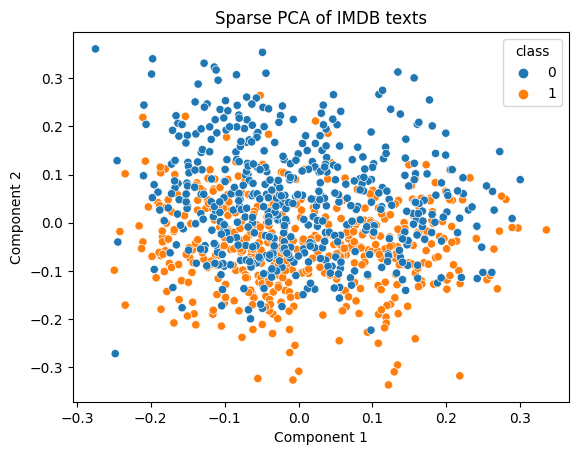

In [133]:
# Now do sparse PCA enforcing sparseness on variables
# that means only a few of the original variables can appear on each latent factor 
sPCA = SparsePCA(n_components=2, random_state=seed, alpha=0.1) # play with alpha to control sparsity. Higher values lead to sparser components. 
sPCA.fit(TfIDF_IMDB.toarray())

# Get the results
Z2 = sPCA.transform(TfIDF_IMDB.toarray())

# Create plot
sns.scatterplot(x=Z2[:, 0], y=Z2[:, 1], hue=texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Sparse PCA of IMDB texts")
plt.show()

What happened? Given that we are forcing only some of the 230 components to be a part of the solution, this actually hurts the ability to get the components. Still, it allows to study if some components are more relevant! Now you would check which ones are actually present, like so.

In [134]:
print(sPCA.components_.shape)
len(word_index[sPCA.components_[0,:] != 0]) # only 60 features (out of 230) showed up on the 1st PC

(2, 230)


60

In [135]:
# Words that are positively correlated to the first component 
word_index[sPCA.components_[0,:] > 0]

array(['actor', 'american', 'audience', 'black', 'character', 'cinema',
       'director', 'does', 'early', 'fact', 'film', 'films', 'fine',
       'given', 'gives', 'isn', 'later', 'little', 'making', 'man',
       'mind', 'old', 'performance', 'place', 'real', 'scenes', 'sense',
       'sex', 'simply', 'small', 'title', 'version', 'way', 'woman',
       'women', 'world', 'years', 'young'], dtype=object)

In [136]:
# Words that are positively correlated to the second component 
word_index[sPCA.components_[1,:] > 0]

array(['10', 'acting', 'actually', 'awful', 'bad', 'believe', 'boring',
       'budget', 'camera', 'couldn', 'did', 'didn', 'don', 'films',
       'funny', 'going', 'got', 'guy', 'hard', 'horror', 'instead',
       'just', 'kind', 'know', 'let', 'like', 'll', 'looks', 'low',
       'make', 'minutes', 'money', 'movie', 'movies', 'oh', 'plot',
       'really', 'reason', 'say', 'scene', 'school', 'seen', 'stupid',
       'supposed', 'terrible', 'thing', 'things', 'think', 'thought',
       'time', 'try', 've', 'video', 'want', 'wanted', 'wasn', 'watch',
       'watched', 'watching', 'way', 'worst', 'wrong'], dtype=object)

As we can see, the first two components are simply referring to the same thing. People that discusses movies and films. Go back and play around with the parameters and see whether you can improve these results.

To get meaningful answers, we need to use truncated Singular Value Decomposition.

## Running [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) Decomposition


This estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently. In particular, truncated SVD works effectively on term count/tf-idf matrices. In that context, it is known as latent semantic analysis (LSA).
Its advantage over PCA is that it works out of the box on sparse data.


Again, we first define it using the TruncatedSVD function.

In [18]:
svd = TruncatedSVD(n_components=100, # How many concepts to extract
                   n_iter=10, # How many iterations to run
                   random_state=seed # Random state. As SVD is rotation-invariant, we need to set this
                  )

As we will apply the model to new data too, we need to first fit the model, not fit and transform simultaneously.

In [138]:
# Train the model!
svd.fit(TfIDF_IMDB)

TruncatedSVD(n_components=100, n_iter=10, random_state=2316)

Now we can dig deeper into the model outputs. First, we calculate the explained variance.

In [139]:
# Get total explained variance in percentage
print('The components explain %.1f%% of total variance.' % (svd.explained_variance_ratio_.sum()*100))
# svd.explained_variance_ratio_

The components explain 67.5% of total variance.


The explained variance is approximately $68\%$ of the total variance using 100 components.

Let's study the relationship between components and words. The matrix *components*, inside our svd object, contains the **principal component matrix**.

In [140]:
# Get component x words matrix
svd.components_

array([[ 0.07091518,  0.03669139,  0.10148825, ...,  0.04572128,
         0.07313572,  0.06054718],
       [ 0.02469027, -0.00422611,  0.0367734 , ..., -0.0275806 ,
        -0.05696519, -0.08565284],
       [-0.00426043,  0.06598767,  0.00636321, ..., -0.00080865,
        -0.00087823,  0.01621592],
       ...,
       [-0.07087589,  0.07568774,  0.07520393, ...,  0.07225494,
         0.06512273, -0.11414982],
       [-0.01325152,  0.03144   ,  0.00809877, ...,  0.08634968,
        -0.07171334,  0.05661747],
       [ 0.04379655,  0.00344163,  0.07602591, ..., -0.04625441,
        -0.05922044,  0.05989558]])

In [141]:
svd.components_.shape

(100, 230)

We can focus on particular words or concepts too. For example, for the word "action" (in place 3) we can get the following weight vector.

In [142]:
word_index[3]

'action'

In [143]:
svd.components_[:, 3]

array([ 4.96830255e-02, -5.86493385e-03,  1.49494151e-03,  1.21966854e-02,
        6.02975581e-02,  8.78991668e-02,  4.38157103e-03, -4.38976564e-02,
        1.90257464e-02,  7.08054289e-02, -7.53166723e-02, -1.48098335e-02,
        3.07884961e-02, -3.65472028e-02, -1.73209793e-02,  2.86628540e-02,
        5.66021153e-02,  7.77773848e-02, -4.69898326e-02,  5.13545177e-02,
        5.74762628e-02, -9.38940920e-02, -5.40916146e-02,  7.87657883e-02,
       -5.80817327e-03, -2.46948513e-02, -1.28463449e-01,  6.08062022e-02,
       -8.67398937e-02, -8.59730303e-02, -8.35262038e-02, -1.64110796e-03,
        4.48650471e-02, -1.56358089e-02, -9.75215413e-02,  2.36148792e-02,
        2.98752867e-02,  1.90161649e-02,  5.26441501e-02,  9.80665974e-02,
        4.33881636e-02, -1.20704287e-01, -5.67092707e-02, -6.29210674e-02,
       -8.52839218e-02, -5.39979090e-02,  1.15074947e-01, -5.18687736e-02,
       -8.86716944e-02, -2.11203539e-05, -2.68664149e-02, -2.59958403e-02,
        1.34798864e-01, -

This means that the word "action" is positively related to concept 1, barely negatively related to concept 2 (i.e. that concept does *not* relate to "action"), etc.

To get the five words that relate the most with concept 2, we need to reorder and sort the vector. This can be tricky, so we will use Numpy's *argpartition* function, which will give us the **unsorted** top X values. See the discussion [here](https://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array).

In [144]:
# To get the second concept, remember that Python starts indexing from 0.
indices = np.argpartition(svd.components_[1, :], -10)[-10:]
indices

array([224, 100, 195, 156,  49, 129, 214, 107, 128,  12])

In [145]:
# Get the words.
word_index[indices]

array(['worst', 'just', 'think', 'really', 'don', 'movies', 'watch',
       'like', 'movie', 'bad'], dtype=object)

As we can see, the second concept appears to relate to "bad movies". Try concept 1; it will relate to "popular movies".

The code below displays the singular values.

In [146]:
# Get singular values
svd.singular_values_

array([11.10436697,  4.12982134,  3.53931525,  3.35608758,  3.30706701,
        3.21351278,  3.13193485,  3.03119431,  2.99741694,  2.96551539,
        2.93676777,  2.90972563,  2.85165396,  2.82596105,  2.8061227 ,
        2.78801269,  2.77714356,  2.75281985,  2.74295261,  2.7199143 ,
        2.71231477,  2.68018781,  2.66353296,  2.64824745,  2.633785  ,
        2.6172013 ,  2.60092836,  2.59270679,  2.57430279,  2.55912687,
        2.54044436,  2.52684045,  2.49827644,  2.496591  ,  2.48889508,
        2.48157005,  2.46714616,  2.45531243,  2.44775664,  2.4432052 ,
        2.43184966,  2.41924802,  2.40805182,  2.39938804,  2.38897652,
        2.37803607,  2.37456708,  2.34991848,  2.34052721,  2.33185775,
        2.32375379,  2.3225586 ,  2.31445876,  2.29977961,  2.29727546,
        2.28533909,  2.27141024,  2.26907965,  2.25429293,  2.24350405,
        2.23545687,  2.22531232,  2.22009313,  2.21279632,  2.20675953,
        2.18604952,  2.17266731,  2.16559233,  2.15714465,  2.15

Now we have a much better way to study these concepts! Of course, now we can study particular concepts or particular words, as desired.

More importantly, we can now train a model over our reduced space, by using directly the components data matrix as our dataset!

## Non-Linear Visualization

Can we improve this analysis using non-linear methods? We will now study the use of t-Distributed Stochastic Neighbor Embedding (t-SNE) and Uniform Manifold Approximation and Projection (UMAP) over the data. We will use two implementations:

1. t-SNE is available in sklearn, in the [sklearn.manifold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) subpackage.
2. The more efficient UMAP is available in its own package, called [umap](https://umap-learn.readthedocs.io/en/latest/basic_usage.html).

### t-SNE

In [147]:
tSNEmapper = TSNE(n_components=2,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=50.0,              # Read below
                  early_exaggeration=12.0,      # Read below
                  learning_rate='auto',         # Related to above. Leave to auto
                  n_iter=5000,                  # Very important to let iterate enough
                  n_iter_without_progress=300,  # Set early stopping
                  metric='euclidean',           # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=0,                    # Verbosity
                  random_state=seed,            # Random seed
                  n_jobs=-1,                    # Parallel processes
                 )

Some parameters in TSNE are extremely important. [This](https://distill.pub/2016/misread-tsne/) is a great paper going into detail in this regard.

In particular:

- Perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. In general, set to a high value and test a few.
- n_iter: The method must converge to be good. Set high and let the min_grad_norm and n_iter_without_progress stop the training.
- Metric: How to measure distances. Can be any keyword [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html). For text, cosine similarity is [known to work](https://academic.oup.com/bioinformatics/article/22/18/2298/318080).

The other parameters are not as significant. Let's train the model!



In [148]:
TSNE_embedding = tSNEmapper.fit_transform(TfIDF_IMDB)

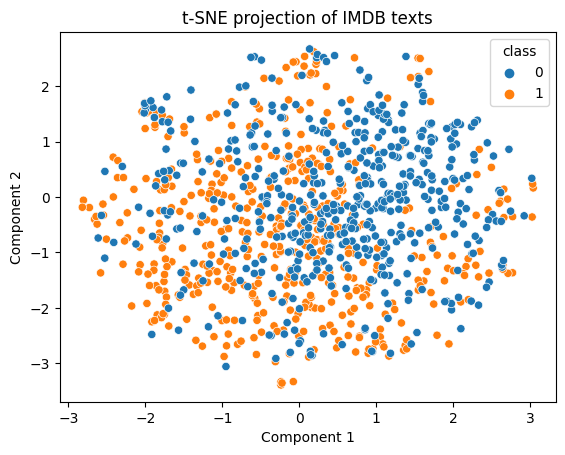

In [149]:
# Create plot
sns.scatterplot(x=TSNE_embedding[:, 0], y=TSNE_embedding[:, 1], hue=texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-SNE projection of IMDB texts")
plt.show()

We can see that the non-linear projection does help separate some of the classes better than PCA. Play around with the parameters to get a better result!

### UMAP

UMAP (Uniform Manifold Approximation and Projection) is a more sophisticated model based on solid mathematical principles. They are fairly sophisticated, so if you want to check them out in detail, read the [original paper](https://arxiv.org/abs/1802.03426). In particular, Appendix C is of great use if you are familiar with Machine Learning notation.

UMAP is far more efficient than t-SNE, particularly when projecting into more than two dimensions, so it is generally a better method than t-SNE. It is, however, still not very mainstream.

Let's create a 2D projection of our data using UMAP, that works great with sparse matrices.

In [150]:
# Let's create the object
reducer = umap.UMAP(n_neighbors=15,              # Number of neareast neighbours to use. 
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric='hellinger',          # Metric to use.
                    n_epochs=None,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=seed,           # Random seed
                    verbose=False                # Verbosity
                   )

# Now we train and calculate the embedding!
UMAP_embedding = reducer.fit_transform(TfIDF_IMDB)

/home/alireza/my_py_env/lib/python3.10/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 74358 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


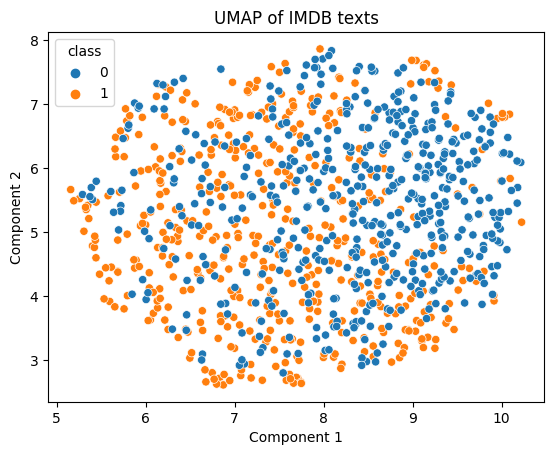

In [151]:
# Create plot
sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=texts['class'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of IMDB texts")
plt.show()

Or alternatively (and using way less memory) we can simply plot the mapper directly.

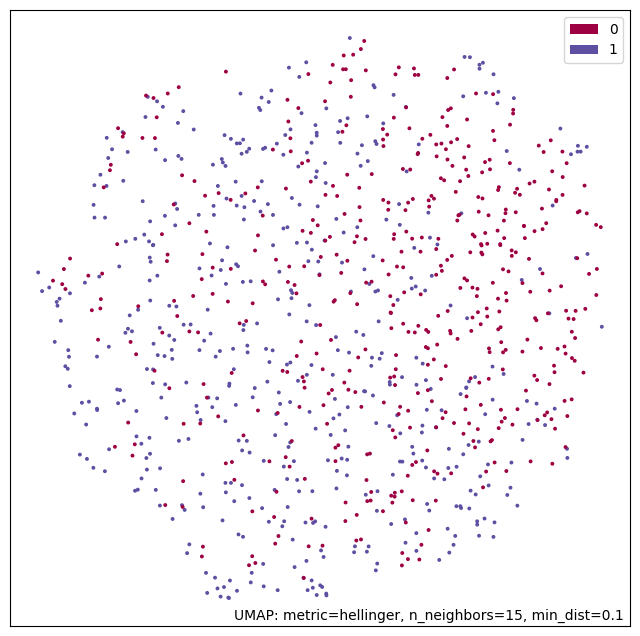

In [152]:
umap.plot.points(reducer, labels=texts['class'])
plt.show()

UMAP and t-SNE create much sparser divisions, and one that clearly separates both classes! What we can infer is that there is a significant non-linear separation between these two movie reviews, and that this can be correctly interpreted using non-linear models.